In [1]:
import pandas as pd

# Load the datasets
exp = pd.read_csv("Tanzania - Food Expenditures (2020-21).csv")
prices = pd.read_csv("Tanzania - Food Prices (2020-21).csv")

# Merge on food item only ('j')
df = pd.merge(exp, prices[['j', 'Price']], on='j', how='left')

# Drop any rows without price information
df = df.dropna(subset=['Price'])

# Compute quantity = expenditure / price
df["Quantity"] = df["Expenditure"] / df["Price"]

# Compute total food expenditure per household
total_exp = df.groupby("i")["Expenditure"].sum().reset_index(name="total_expenditure")

# Merge total back into main dataframe
df = df.merge(total_exp, on="i")

# Calculate share of budget spent on each item
df["share"] = df["Expenditure"] / df["total_expenditure"]

print("Data merged and quantities calculated.")

Data merged and quantities calculated.


In [2]:
# Median household food budget
reference_budget = df["total_expenditure"].median()

# Median share of food items across all households
reference_shares = df.groupby("j")["share"].median()

# Median prices of items
reference_prices = df.groupby("j")["Price"].median()

# Calculate reference quantities
reference_quantities = (reference_shares * reference_budget) / reference_prices

print("Reference quantities:")
print(reference_quantities.sort_values(ascending=False).head(10))

Reference quantities:
j
Maize (flour)        5.373279
Seeds                5.104362
Cassava Dry/Flour    3.925612
Eggs                 3.819091
Rice (husked)        3.730304
Plantains            3.302964
Sweet Potatoes       3.077690
Coconuts             2.971713
Cassava Fresh        2.594867
Other Fruits         2.433916
dtype: float64


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Marshallian demand function
def marshallian_demand(budget, shares, prices):
    return (shares * budget) / prices

# Function to change price of one item
def custom_prices(item, new_price):
    prices = reference_prices.copy()
    prices[item] = new_price
    return prices

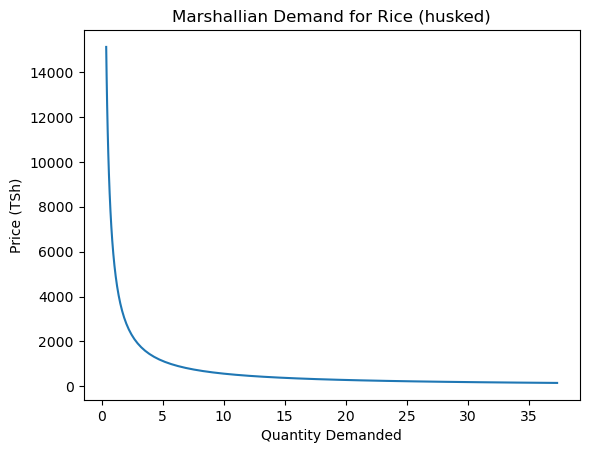

In [4]:
item = "Rice (husked)"  # Change to any other item to analyze
P = np.geomspace(0.1, 10, 50) * reference_prices[item]  # Price range

# Calculate Marshallian demand for different prices
marshallian = [
    marshallian_demand(reference_budget, reference_shares, custom_prices(item, p))[item]
    for p in P
]

# Plot the demand curve
plt.plot(marshallian, P)
plt.xlabel("Quantity Demanded")
plt.ylabel("Price (TSh)")
plt.title(f"Marshallian Demand for {item}")
plt.show()

In [5]:
# Hicksian demand function (keeping utility constant)
def indirect_utility(budget, prices, shares):
    return budget / np.prod(prices ** shares)

def hicksian_demand(U, prices, shares):
    return (U * shares) / prices

# Welfare calculations
def compensating_variation(U, p0, p1, shares):
    q0 = hicksian_demand(U, p0, shares)
    return ((p1 - p0) * q0).sum()

def tax_revenue(p0, p1, q1):
    return ((p1 - p0) * q1).sum()

def deadweight_loss(cv, rev):
    return cv - rev

In [6]:
# Set up
item = "Rice (husked)"
p0 = reference_prices
p1 = custom_prices(item, 2 * reference_prices[item])  # Double price

# Indirect utility under base prices
U0 = indirect_utility(reference_budget, reference_prices, reference_shares)

# Hicksian demand at new prices
q1 = hicksian_demand(U0, p1, reference_shares)

# Calculate CV, tax revenue, and DWL
cv = compensating_variation(U0, p0, p1, reference_shares)
rev = tax_revenue(p0, p1, q1)
dwl = deadweight_loss(cv, rev)

# Output results
print(f"Compensating Variation: {cv:,.2f} TSh")
print(f"Tax Revenue: {rev:,.2f} TSh")
print(f"Deadweight Loss: {dwl:,.2f} TSh")

Compensating Variation: 86.78 TSh
Tax Revenue: 43.39 TSh
Deadweight Loss: 43.39 TSh
